In [278]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV
import itertools
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import numpy as np
from numpy import arange
from sklearn.model_selection import RepeatedKFold
import sys
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')
    
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [279]:
def read_data():
    df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')
    return(df)

In [280]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [281]:
independent = 'Poverty'

In [282]:
y = read_data()[[independent]]
X = read_data()[(read_data().columns).difference([independent]).values]

In [283]:
estimators = []
estimators.append(('standardize', ZCA()))
estimators.append(('ElasticNetCV', ElasticNetCV(cv=10, random_state=0)))
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
#estimators.append(('ElasticNetCV', ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)))
model_en = Pipeline(estimators)

model_en.fit(X, y)
#print('alpha: %f' % model.alphas)
#print('l1_ratio_: %f' % model.l1_ratio)


Pipeline(steps=[('standardize', ZCA()),
                ('ElasticNetCV', ElasticNetCV(cv=10, random_state=0))])

In [284]:
model_en.score(X,y)

0.8609356681998442

In [285]:
model_en.get_params()

{'memory': None,
 'steps': [('standardize', ZCA()),
  ('ElasticNetCV', ElasticNetCV(cv=10, random_state=0))],
 'verbose': False,
 'standardize': ZCA(),
 'ElasticNetCV': ElasticNetCV(cv=10, random_state=0),
 'standardize__copy': False,
 'standardize__regularization': 1e-06,
 'ElasticNetCV__alphas': None,
 'ElasticNetCV__copy_X': True,
 'ElasticNetCV__cv': 10,
 'ElasticNetCV__eps': 0.001,
 'ElasticNetCV__fit_intercept': True,
 'ElasticNetCV__l1_ratio': 0.5,
 'ElasticNetCV__max_iter': 1000,
 'ElasticNetCV__n_alphas': 100,
 'ElasticNetCV__n_jobs': None,
 'ElasticNetCV__normalize': False,
 'ElasticNetCV__positive': False,
 'ElasticNetCV__precompute': 'auto',
 'ElasticNetCV__random_state': 0,
 'ElasticNetCV__selection': 'cyclic',
 'ElasticNetCV__tol': 0.0001,
 'ElasticNetCV__verbose': 0}

In [286]:
results = cross_val_score(model_en, X, y, cv=cv)

In [287]:
results

array([ 0.6359295 ,  0.89726432,  0.94487683,  0.63892249,  0.67139652,
       -0.13444101,  0.80174153,  0.90693939,  0.83291332,  0.41320671,
        0.93914589,  0.80081269,  0.28881888,  0.30030918,  0.90993784,
        0.69230169,  0.67620445,  0.66781782,  0.75809788,  0.87535852,
        0.60698596,  0.81575621,  0.89281156,  0.97067134,  0.43092841,
        0.15104642,  0.07861483,  0.68202931,  0.86368869,  0.65555619])

In [288]:
#X, y = make_regression(n_features=2, random_state=0)
#regr = ElasticNetCV(cv=10, random_state=0)
#regr.fit(X, y)
#print(regr.alpha_)
#print(regr.intercept_)
#print(regr.predict(X))

In [289]:


rmse_enet = mean_squared_error(y, model_en.predict(X), squared=True)
rmse_enet

1.1771762311443557

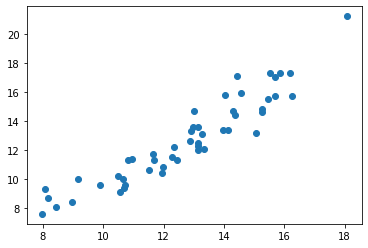

In [290]:
plt.scatter(model_en.predict(X),y)

In [291]:
#chosen_model = ElasticNet(alpha=model.named_steps['ElasticNetCV'].alpha_, l1_ratio=model.named_steps['ElasticNetCV'].l1_ratio)
#chosen_model.fit(X,y)

In [292]:
#plt.scatter(chosen_model.predict(X),y)

In [293]:
#pd.DataFrame(model.predict(X)-chosen_model.predict(X)).hist()

In [294]:
#trying to elastic net manually.  There is a formula 
#pd.DataFrame(np.array(pd.DataFrame([model.named_steps['ElasticNetCV'].coef_,]))*np.array(zca.fit_transform(X)),columns=X.columns).set_index(y.index).sum(axis=1).sort_values(axis=0)

In [295]:
#pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV),model.named_steps['ElasticNetCV'].coef_

In [310]:
filtered_eNetCV = X.columns[model_en.named_steps['ElasticNetCV'].coef_!=0]

#from statsmodels.formula.api import ols
sm_model = sm.OLS(y, sm.add_constant(X[filtered_eNetCV])).fit()
print(sm_model.summary())

rmse_linear = mean_squared_error(y, sm_model.predict(sm.add_constant(X[filtered_eNetCV])), squared=True)
print(rmse_linear)
zca = ZCA()
sm_model_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV)).set_index(y.index)).fit()
#sm_model_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV)).set_index(y.index)).fit()

print(sm_model_zca.summary())

rmse_linear = mean_squared_error(y, sm_model_zca.predict(sm.add_constant(zca.fit_transform(X[filtered_eNetCV]))), squared=True)
rmse_linear


                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     42.47
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           4.79e-17
Time:                        19:46:37   Log-Likelihood:                -72.116
No. Observations:                  50   AIC:                             160.2
Df Residuals:                      42   BIC:                             175.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          26.0438      3.622      7.190      

1.047869360518312

In [297]:
#model.named_steps['standardize'].fit_transform(X)*model.named_steps['ElasticNetCV'].coef_

#model.named_steps['standardize'].fit_transform(X)
#pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV),model.named_steps['ElasticNetCV'].alpha_
#pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV),model.named_steps['ElasticNetCV'].l1_ratio


In [298]:
#pd.DataFrame([model.named_steps['standardize'].coef_],columns=X.columns)

In [299]:
#pd.DataFrame([model.named_steps['ElasticNetCV'].coef_],columns=X.columns)

In [300]:
X.columns

Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')

In [301]:
def fit_linear_score(X,Y):
    #Fit linear regression model and return RSS and R squared values
    zca = ZCA()
        
    estimators = []
    estimators.append(('standardize', ZCA()))

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    estimators.append(('Linear', ElasticNet(alpha=0, l1_ratio=0,fit_intercept = True)))
    
    model_k = Pipeline(estimators)
    #model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared
    
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables

k = len(X.columns)

RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        #zca = StandardScaler()
        
        #linear regression with CV
        
        #estimators.append(('ElasticNetCV', ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)))

        model_en_ = fit_linear_score(X[list(combo)],y)
        
        #model_en_.fit(X, y)

        #tmp_result = model.predict(fit_linear_reg(pd.DataFrame(zca.fit_transform(X[list(combo)]),columns=X[list(combo)].columns),y)   #Store temp result 
        #tmp_result = model_en_.predict(zca.fit_transform(X[list(combo)]))  #Store temp result 
        RSS_list.append(model_en_[0])                  #Append lists
        R_squared_list.append(model_en_[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df_cv = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})    


Loop...:   0%|          | 0/9 [00:00<?, ?it/s]

                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     31.93
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           1.59e-15
Time:                        19:44:40   Log-Likelihood:                -71.791
No. Observations:                  50   AIC:                             163.6
Df Residuals:                      40   BIC:                             182.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.7320      0.161     79.177      

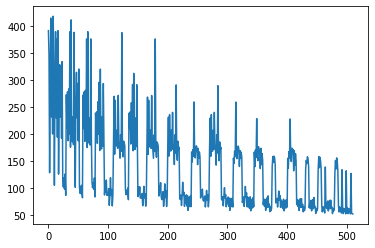

['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population', 'Traf Deaths', 'Unemployed', 'University', 'White']


1.0343189050835662

In [302]:
bestLinear = pd.Series(df_cv.iloc[np.argmin(df_cv['RSS'])]['features']).to_list()

zca = ZCA()
sm_model_linear_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[bestLinear]),columns=bestLinear).set_index(y.index))).fit()
#sm_model_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV)).set_index(y.index)).fit()

print(sm_model_linear_zca.summary())

plt.plot(df_cv['RSS'])
plt.show()
print(bestLinear)

rmse_linear = mean_squared_error(y, sm_model_linear_zca.predict(sm.add_constant(pd.DataFrame(zca.fit_transform(X[bestLinear]),columns=bestLinear).set_index(y.index))), squared=True)
rmse_linear

In [303]:
sfs = SFS(ElasticNet(alpha=0, l1_ratio=0), 
          k_features=len(X.columns), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

estimators = []
estimators.append(('standardize', ZCA()))
estimators.append(('SFS', SFS(ElasticNet(alpha=0, l1_ratio=0), 
          k_features=len(X.columns), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)))
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model_sfs = Pipeline(estimators)
model_sfs.fit(X, y)
#sfs = sfs.fit(X, y)
#fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

#plt.title('Sequential Forward Selection (w. StdErr)')
#plt.grid()
#plt.show()
model_sfs

Pipeline(steps=[('standardize', ZCA()),
                ('SFS',
                 SequentialFeatureSelector(cv=10,
                                           estimator=ElasticNet(alpha=0,
                                                                l1_ratio=0),
                                           k_features=9,
                                           scoring='neg_mean_squared_error'))])

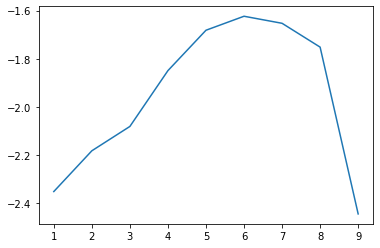

In [304]:
plt.plot(pd.DataFrame(model_sfs.named_steps['SFS'].subsets_).loc['avg_score'])

In [305]:

bestSFS=X.columns[pd.Series(pd.DataFrame(model_sfs.named_steps['SFS'].subsets_).iloc[:,np.argmin(np.abs(pd.DataFrame(model_sfs.named_steps['SFS'].subsets_).loc['avg_score']))-1].feature_idx).to_list()]

In [306]:
bestSFS

Index(['Crime', 'Income', 'Population', 'Unemployed', 'White'], dtype='object')

In [307]:
zca = ZCA()
sm_model_linear_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[bestSFS]),columns=bestSFS).set_index(y.index))).fit()
#sm_model_zca = sm.OLS(y, sm.add_constant(pd.DataFrame(zca.fit_transform(X[filtered_eNetCV]),columns=filtered_eNetCV)).set_index(y.index)).fit()

print(sm_model_linear_zca.summary())

rmse_linear = mean_squared_error(y, sm_model_linear_zca.predict(sm.add_constant(pd.DataFrame(zca.fit_transform(X[bestSFS]),columns=bestSFS).set_index(y.index))), squared=True)
rmse_linear

                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     55.14
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           7.69e-18
Time:                        19:44:43   Log-Likelihood:                -74.766
No. Observations:                  50   AIC:                             161.5
Df Residuals:                      44   BIC:                             173.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7320      0.163     78.244      0.0

1.1650540343581808

                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     42.47
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           4.79e-17
Time:                        19:44:44   Log-Likelihood:                -72.116
No. Observations:                  50   AIC:                             160.2
Df Residuals:                      42   BIC:                             175.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.7320      0.158     80.606      

1.047869360518312